# Sesión 9: Análisis no Supervisado con Deep Learning

## Programa de Formación en ML & DS
## [Universidad Nacional de Colombia](https://unal.edu.co)

En este notebook daremos una breve introducción a métodos no supervisados de deep learning. Mostraremos algunos ejemplos de autoencoders y de redes generativas adversarias:



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
%matplotlib inline
plt.style.use("ggplot")
# Seleccionamos una semilla para los RNG
tf.random.set_seed(123)
np.random.seed(123)

## 1. Autoencoders

Los autoencoders son un tipo especial de redes neuronales que son típicamente usados en problemas no supervisados y de reducción de dimensionalidad. Se trata de un tipo de arquitecturas que busca beneficiarse de *representation learning*.

En general, con los autoencoders se busca imponer una restricción de *cuello de botella* con el fin de obtener una representación más compacta de los datos. Un ejemplo típico de la arquitectura de un autoencoder se puede ver a continuación:

![autoencoder](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.24.37-AM.png)

Veamos algunos componentes generales que conforman un autoencoder:

* **Encoder**: se trata de una red neuronal que transforma los datos a un espacio de menor dimensionalidad o espacio latente.
* **Decoder**: se trata de una red neuronal que transforma los datos del espacio latente al espacio original.

Típicamente, un autoencoder busca reconstruír los datos de entrada utilizando una representación latente. Esto se consigue al optimizar la siguiente función de pérdida:

$$
\mathcal{L}=\frac{1}{N}\sum_{i=1}^N ||x_i-\widetilde{x}_i||^2
$$

Donde $x_i$ es una observación original y $\widetilde{x}_i$ está dado por:

$$
\widetilde{x}_i = \text{decoder}(\text{encoder}(x_i))
$$

Como podemos ver, es un concepto muy simple pero su aplicación es bastante útil y possee propiedades bastante interesantes, veamos un ejemplo de esto en tensorflow. Primero vamos a cargar un dataset de imágenes:

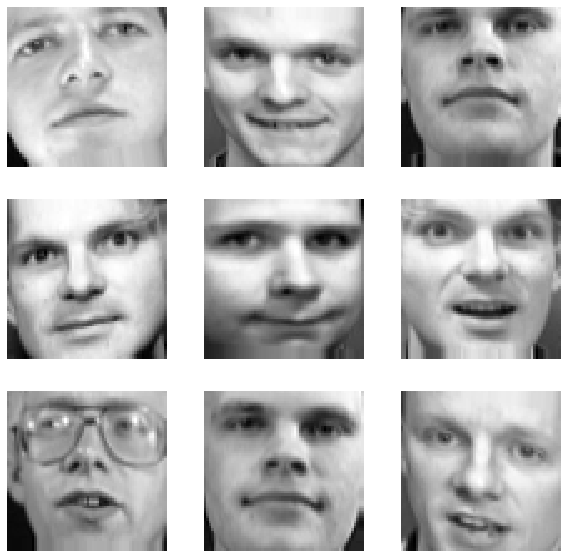

In [2]:
import make_dataset
images_gen = make_dataset.get_faces_dataset()
# Veamos un ejemplo de las imagenes
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
batch = next(images_gen)
for i in range(9):
    ax[i//3, i%3].imshow(batch[0][i, :, :, 0], "gray")
    ax[i//3, i%3].axis("off")

En este caso tenemos un dataset que nos devuelve los datos de entrada y salida para un autoencoder (la entrada y la salida deben ser iguales):

In [3]:
print("Tamaño de un batch de entrada:")
print(batch[0].shape)
print("Tamaño de un batch de salida:")
print(batch[1].shape)

Tamaño de un batch de entrada:
(32, 64, 64, 1)
Tamaño de un batch de salida:
(32, 64, 64, 1)


Ahora, pasaremos a definir nuestro autoencoder utilizando convoluciones:

In [4]:
# Definimos el tamaño de la dimensión latente
latent_dim = 200

In [5]:
# Definimos el encoder
encoder_model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(64, 64, 1)),
                                            tf.keras.layers.Conv2D(32, kernel_size=9, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2D(64, kernel_size=7, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2D(128, kernel_size=5, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Flatten(),
                                            tf.keras.layers.Dense(latent_dim, activation="linear")])
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        100416    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1638600   
Total params: 1,946,568
Trainable params: 1,946,568
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Definimos el decoder
decoder_model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(latent_dim, )),
                                            tf.keras.layers.Dense(4096),
                                            tf.keras.layers.Reshape((8, 8, 64)),
                                            tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2DTranspose(64, kernel_size=7, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2DTranspose(32, kernel_size=9, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2DTranspose(1, kernel_size=9, activation="linear", padding="same")])
decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        401472    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 32)        165920    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 1)         2593      
Total params: 1,598,209
Trainable params: 1,598,209
Non-trainable params: 0
____________________________________________

In [7]:
# Definimos el autoencoder completo
ae_in = tf.keras.layers.Input(shape=(64, 64, 1))
ae_out = decoder_model(encoder_model(ae_in))
ae_model = tf.keras.Model(inputs=[ae_in], outputs=[ae_out])
# Especificamos la pérdida y el optimizador
ae_model.compile(loss="mse", optimizer=tf.optimizers.Adam(lr=1e-4))

Ahora, entrenemos el modelo:

In [8]:
ae_model.fit(images_gen, steps_per_epoch=10, epochs=1000)

  ...
    to  
  ['...']
Train for 10 steps
Epoch 1/1000
10/10 [==============================] - 3s 261ms/step - loss: 0.2807
Epoch 2/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0972
Epoch 3/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0491
Epoch 4/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0312
Epoch 5/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0264
Epoch 6/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0234
Epoch 7/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.0218
Epoch 8/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0197
Epoch 9/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0190
Epoch 10/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0183
Epoch 11/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0171
Epoch 12/1000
10/10 [==============================

In [9]:
ae_model.save_weights("ae.h5")

Veamos la pérdida a lo largo de las épocas:

Text(0, 0.5, 'Loss')

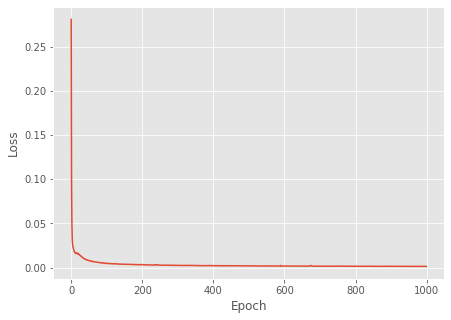

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(ae_model.history.history["loss"])
plt.xlabel("Epoch"); plt.ylabel("Loss")

Ahora veamos algunas aplicaciones interesantes de los autoencoders:

### Reconstrucción

Podemos ver qué tanta información se está perdiendo al comprimir las imágenes:

Text(0.5, 1.0, 'Reconstrucción')

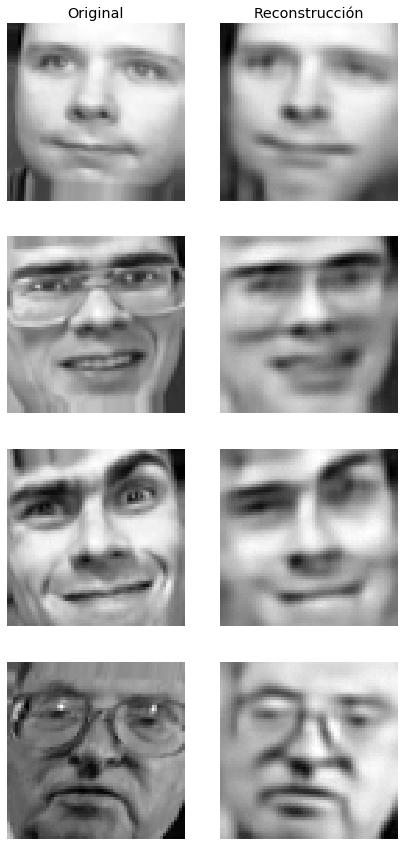

In [11]:
# Obtenemos un batch de imagenes del generador
batch = next(images_gen)[0]
# Obtenemos la reconstrucción usando el autoencoder
reconstruction = ae_model.predict(batch)
# Visualizamos 4 ejemplos
fig, ax = plt.subplots(4, 2, figsize=(7, 15))
for i in range(4):
    ax[i, 0].imshow(batch[i, :, :, 0], "gray"); ax[i, 0].axis("off")
    ax[i, 1].imshow(reconstruction[i, :, :, 0], "gray"); ax[i, 1].axis("off")
ax[0, 0].set_title("Original"); ax[0, 1].set_title("Reconstrucción")

### Espacio latente

Podemos explorar las propiedades de las representaciones en el espacio latente (promediar rostros), veamos un ejemplo:

In [12]:
# Seleccionamos el índice de dos imágenes dentro del batch
idx1 = 0; idx2 = 2

(-0.5, 63.5, 63.5, -0.5)

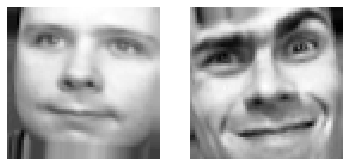

In [13]:
# Veamos las dos imágenes originales
im1 = batch[idx1]
im2 = batch[idx2]
plt.subplot(121)
plt.imshow(im1[:, :, 0], "gray"); plt.axis("off")
plt.subplot(122)
plt.imshow(im2[:, :, 0], "gray"); plt.axis("off")

Primero obtenemos las representaciones en el espacio latente de estas dos imágenes:

In [14]:
# Codificamos el batch de imágenes
preds = encoder_model.predict(batch)
# Obtenemos la representación de cada imagen
latent1 = preds[idx1]
latent2 = preds[idx2]
print(f"Tamaño de la primer representación: {latent1.shape}")
print(f"Tamaño de la segunda representación: {latent2.shape}")

Tamaño de la primer representación: (200,)
Tamaño de la segunda representación: (200,)


Ahora, vamos a realizar una combinación convexa:

$$
x_{comb} = \alpha x_1 + (1-\alpha) x_2
$$

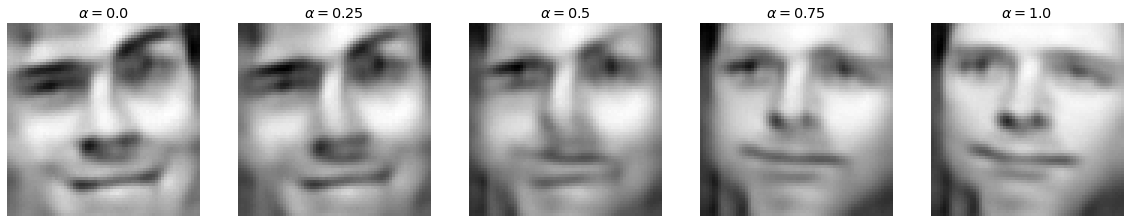

In [15]:
alpha = np.linspace(0, 1, 5)
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    x_comb = latent1*alpha[i]+latent2*(1-alpha[i])
    reconstruction = decoder_model.predict(x_comb.reshape(1, -1))
    ax[i].imshow(reconstruction[0, :, :, 0], "gray")
    ax[i].axis("off"); ax[i].set_title(r"$\alpha=$"+f"{alpha[i]}")

### Generación de imágenes

Podemos generar imágenes de forma automática de forma muy sencilla, tenemos que generar vectores aleatorios en el espacio latente y utilizar el decoder para reconstruír, veamos un ejemplo:

In [16]:
# Obtenemos el rango de las imagenes
latent = encoder_model.predict(batch)
# Media y desviación estándar en cada dimensión del espacio latente
mean = latent.mean(axis=0)
std = latent.std(axis=0)
# Creamos una función para generar valores aleatorios en los rangos de cada dimensión
latent_rng = lambda : np.array([np.random.normal(m, s) for m, s in zip(mean, std)]).reshape(1, -1)

Veamos un ejemplo

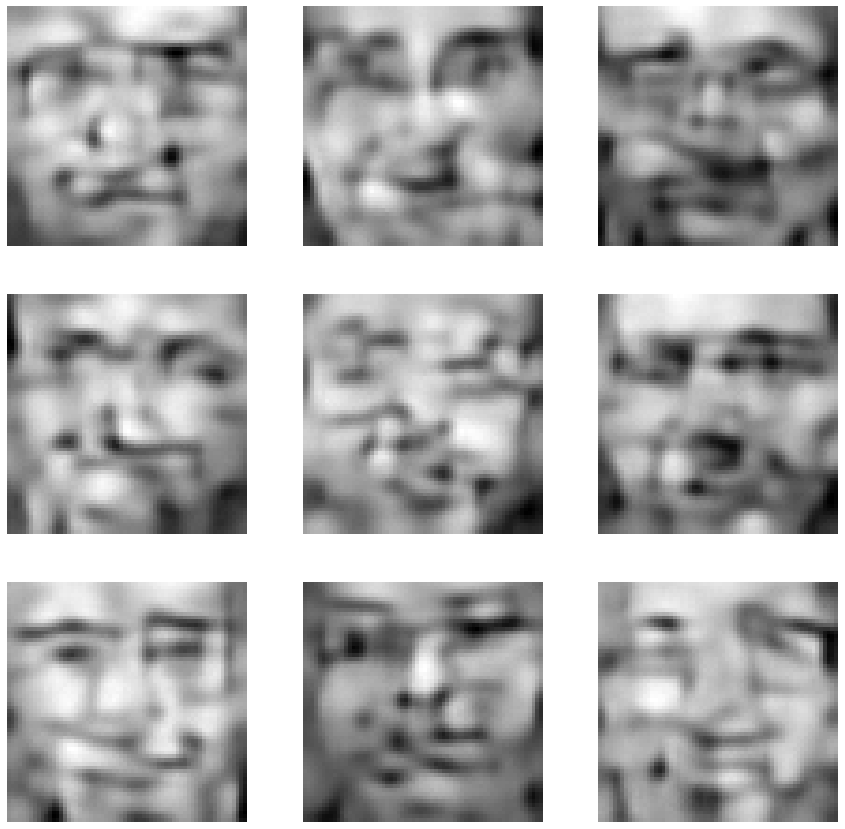

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    random_vector = latent_rng()
    reconstruction = decoder_model.predict(random_vector)
    ax[i//3, i%3].imshow(np.squeeze(reconstruction), "gray")
    ax[i//3, i%3].axis("off")

Aunque podemos identificar algunos patrones, este método no es muy bueno. Esto se debe fundamentalmente a que el modelo aprende unas representaciones que no necesariamente siguen una distribución normal (la cual usamos para generar los vectores). Sin embargo, existen otras técnicas de deep learning para análisis no supervisado que funcionan mejor en estos casos.

## Autoencoder Variacional

El autoencoder variacional (variational autoencoder - VAE) es un modelo generativo basado en autoencoders, el cual busca que el espacio latente represente los parámetros de una distribución.

Lo más típico es utilizar una distribución normal, para ello, el espacio latente debe representar sus parámetros, es decir, una media $\mu$ y una covarianza $\mathbf{\Sigma}$ (puede ser un vector de varianzas asumiendo que no hay correlación en el espacio latente).

![vae](http://www.cs.us.es/~fsancho/images/2020-03/vae2.png)

Un VAE difiere de un autoencoder típico en dos aspectos fundamentales:

* La representación latente en un VAE está conformada por dos capas (media y varianza), el decoder utiliza una muestra generada con los parámetros estimados por el encoder:

$$
\mu_i, \sigma_i = \text{encoder(x_i)}\\
z_i \sim \mathcal{N}(\mu_i, \sigma_i)\\
\tilde{x}_i = \text{decoder}(z_i)
$$

* La pérdida se conforma de dos cosas, una pérdida de reconstrucción $\mathcal{L}_1$ igual a la de los autoencoders típicos y un término de regularización $\mathcal{L}_2$ el cual busca que que las distribuciones generadas por el encoder se parezcan a una distribución normal estándar.

$$
\mathcal{L}= \lambda_1\mathcal{L}_1+\lambda_2\mathcal{L}_2\\
\mathcal{L}_1 = \text{MSE}(x_i, \tilde{x}_i)\\
\mathcal{L}_2 = \text{KL}(\mathcal{N}(\mu_i, \sigma_i)|| \mathcal{N}(0, 1))
$$

La divergencia de Kullback-Leibler es una médida que nos permite ver qué tan parecidas son dos distribuciones, en este caso, buscamos que el espacio latente aproxime una distribución normal con media 0 y desviación estándar de 1.

El detalle en la implementación del autoencoder variacional lo puede revisar en el archivo vae.py. En este notebook nos enfocaremos en el entrenamiento y la definición del encoder y el decoder:

In [18]:
# Descargamos e importamos el código de la implementación de un vae
import vae

In [19]:
# Especificamos el tamaño en el espacio latente
latent_dim = 200

Comenzaremos definiendo el encoder. Usaremos la misma arquitectura de antes agregando una salida adicional que representa a las varianzas:

In [20]:
inp = tf.keras.layers.Input(shape=(64, 64, 1))
lay1 = tf.keras.layers.Conv2D(32, kernel_size=9, strides=(2, 2), activation="relu", padding="same")(inp)
lay2 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=(2, 2), activation="relu", padding="same")(lay1)
lay3 = tf.keras.layers.Conv2D(128, kernel_size=5, strides=(2, 2), activation="relu", padding="same")(lay2)
lay4 = tf.keras.layers.Flatten()(lay3)
mean = tf.keras.layers.Dense(latent_dim, activation="linear")(lay4)
var = tf.keras.layers.Dense(latent_dim, activation="linear")(lay4)
encoder_model = tf.keras.Model(inputs=[inp], outputs=[mean, var])
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   2624        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   100416      conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 128)    204928      conv2d_4[0][0]                   
____________________________________________________________________________________________

Ahora, definimos la arquitectura del decoder:

In [21]:
decoder_model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(latent_dim, )),
                                            tf.keras.layers.Dense(4096),
                                            tf.keras.layers.Reshape((8, 8, 64)),
                                            tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2DTranspose(64, kernel_size=7, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2DTranspose(32, kernel_size=9, strides=(2, 2), activation="relu", padding="same"),
                                            tf.keras.layers.Conv2DTranspose(1, kernel_size=9, activation="linear", padding="same")])
decoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 64)        401472    
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 64, 64, 32)        165920    
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 64, 64, 1)         2593      
Total params: 1,598,209
Trainable params: 1,598,209
Non-trainable params: 0
____________________________________________

Por último, definimos el autoencoder variacional completo. La implementación requiere:

* `encoder`: modelo en `tf.keras` con la arquitectura del encoder.
* `decoder`: modelo en `tf.keras` con la arquitectura del decoder.
* `latent_dim`: dimensión del espacio latente.
* `input_shape`: tamaño de los tensores de entrada.
* `loss_params`: lista con los pesos $\lambda_i$ que ponderan las pérdidas.

In [22]:
vae_model = vae.VAE(encoder_model, decoder_model, 200, (64, 64, 1), loss_params=[1, 0.1])
vae_model.compile_model()

Entrenamos el modelo:

In [23]:
vae_model.model.fit(images_gen, steps_per_epoch=10, epochs=1000)

  ...
    to  
  ['...']
Train for 10 steps
Epoch 1/1000
10/10 [==============================] - 1s 84ms/step - loss: 2770.0737
Epoch 2/1000
10/10 [==============================] - 0s 19ms/step - loss: 1196.4858
Epoch 3/1000
10/10 [==============================] - 0s 21ms/step - loss: 1155.6067
Epoch 4/1000
10/10 [==============================] - 0s 19ms/step - loss: 1084.3044
Epoch 5/1000
10/10 [==============================] - 0s 18ms/step - loss: 1059.5125
Epoch 6/1000
10/10 [==============================] - 0s 17ms/step - loss: 987.8589
Epoch 7/1000
10/10 [==============================] - 0s 19ms/step - loss: 910.3535
Epoch 8/1000
10/10 [==============================] - 0s 19ms/step - loss: 829.8116
Epoch 9/1000
10/10 [==============================] - 0s 20ms/step - loss: 722.7280
Epoch 10/1000
10/10 [==============================] - 0s 17ms/step - loss: 639.0693
Epoch 11/1000
10/10 [==============================] - 0s 19ms/step - loss: 509.6610
Epoch 12/1000
10/10 [====

La generación de imágenes nuevas es muy sencilla, especialmente, como la pérdida buscaba que el espacio latente tenga una distribución normal estándar, para obtener vectores válidos en dicho espacio basta con generar un vector de esta distribución.

Veamos un ejemplo:

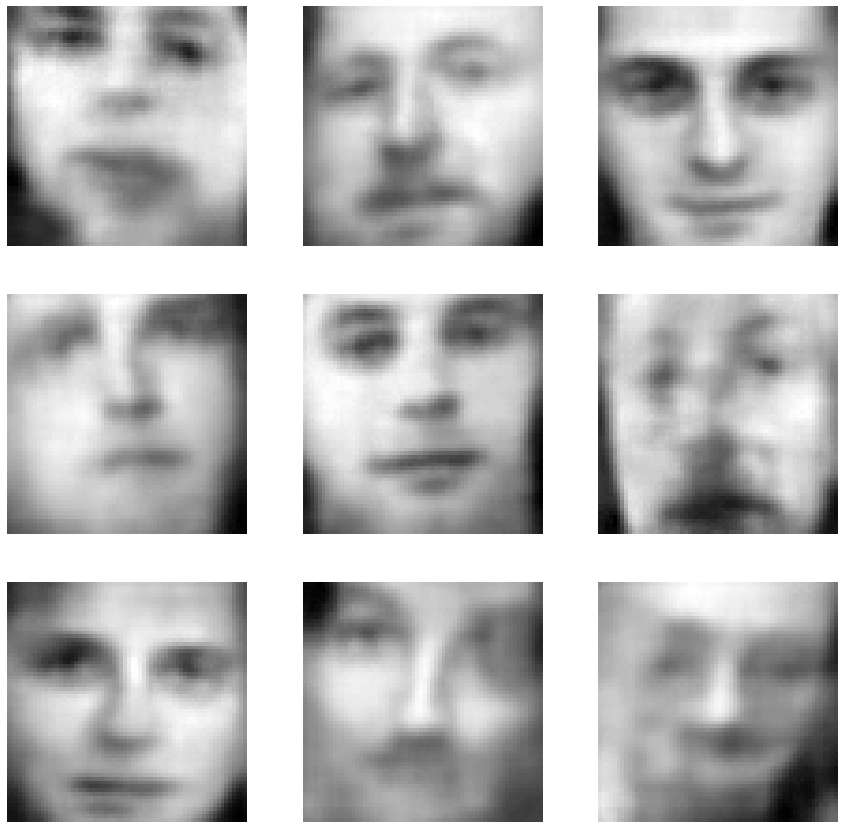

In [28]:
# algunas veces el modelo no converge a una distribución estándar,
# puede probar con valores distintos para la media y ver cómo se comporta el modelo.
#random_vectors = np.float32(np.random.normal(1, 1, size=(9, 200)))
random_vectors = np.float32(np.random.normal(0, 1, size=(9, 200)))
imgs = decoder_model(random_vectors)
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    ax[i//3, i%3].imshow(np.squeeze(imgs[i]), "gray")
    ax[i//3, i%3].axis("off")

También podemos explorar las relaciones en el espacio latente de la misma forma que lo hicimos con los autoencoders estándar, para ello, vamos a tomar una combinación convexa de dos puntos generados aleatoriamente:

In [ ]:
alpha = np.linspace(0, 1, 5)
latent1 = np.random.normal(0, 1, size=(1, latent_dim))
latent2 = np.random.normal(0, 1, size=(1, latent_dim))
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    x_comb = latent1*alpha[i]+latent2*(1-alpha[i])
    reconstruction = decoder_model.predict(x_comb.reshape(1, -1))
    ax[i].imshow(reconstruction[0, :, :, 0], "gray")
    ax[i].axis("off"); ax[i].set_title(r"$\alpha=$"+f"{alpha[i]}")

### Redes Generativas Adversarias

Las redes generativas adversarias (Generative Adversarial Networks - GAN) son otro tipo de modelos generativos que utilizan redes neuronales. Una GAN rompe el esquema tradicional de encoder-decoder y propone dos componentes:

* Generador: se trata de una arquitectura parecida a un decoder, cuya función es transformar vectores aleatorios al espacio de las imágenes.
* Discriminador: se trata de una arquitectura que buscará identificar si una imagen generada es real o falsa. 

En otros términos, una GAN se compone de dos modelos que están compitiendo constantemente. Por un lado, el generador busca mejorar sus predicciones para engañar al discriminador. Por otro, el discriminador busca ser más preciso para detectar qué imágenes son producidas aritificialmente en el generador y qué imágenes son reales (del dataset).

![gan](https://pbs.twimg.com/media/DawGfxdXUAAm6V2.jpg)

Veamos el funcionamiento de una GAN, los detalles de la implementación los podrá consultar en el archivo gan.py, en este notebook nos enfocaremos en el entrenamiento y en la definición del generador y discriminador:

In [ ]:
import gan

In [ ]:
# Especificamos el tamaño en el espacio latente
latent_dim = 200

Comenzaremos definiendo el generador, el cual tendrá la misma arquitectura del decoder que usamos anteriormente:

In [ ]:
generator_model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(latent_dim, )),
                                              tf.keras.layers.Dense(4096),
                                              tf.keras.layers.Reshape((8, 8, 64)),
                                              tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=(2, 2), activation="relu", padding="same"),
                                              tf.keras.layers.Conv2DTranspose(64, kernel_size=7, strides=(2, 2), activation="relu", padding="same"),
                                              tf.keras.layers.Conv2DTranspose(32, kernel_size=9, strides=(2, 2), activation="relu", padding="same"),
                                              tf.keras.layers.Conv2DTranspose(1, kernel_size=9, activation="linear", padding="same")])
generator_model.summary()

Ahora definiremos la arquitectura del discriminador:

In [ ]:
discriminator_model = tf.keras.Sequential([tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same",
                                                                  input_shape=(64, 64, 1), activation="relu"),
                                           tf.keras.layers.Dropout(0.2),
                                           tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same",
                                                                  input_shape=(64, 64, 1), activation="relu"),
                                           tf.keras.layers.Dropout(0.2),
                                           tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same",
                                                                  input_shape=(64, 64, 1), activation="relu"),
                                           tf.keras.layers.Dropout(0.2),
                                           tf.keras.layers.Conv2D(512, kernel_size=3, strides=2, padding="same",
                                                                  input_shape=(64, 64, 1), activation="relu"),
                                           tf.keras.layers.Flatten(),
                                           tf.keras.layers.Dense(1, activation="sigmoid")])
discriminator_model.summary()

Por último, definimos el modelo completode la GAN. La implementación requiere:

* `generator`: modelo en tf.keras con la arquitectura del generador.
* `discriminator`: modelo en tf.keras con la arquitectura del discriminador.
* `optimizer_gen`: optimizador para el generador.
* `optimizer_dis`: optimizador para el discriminador.
* `batch_size`: tamaño de batch.
* `latent_dim`: dimensión en el espacio latente.

In [ ]:
gan_model = gan.GAN(generator_model, discriminator_model,
                    optimizer_gen = tf.optimizers.Adam(lr=0.5e-4),
                    optimizer_dis = tf.optimizers.Adam(lr=2e-4),
                    batch_size=32, latent_dim=latent_dim)

Entrenamos el modelo

In [ ]:
gan_model.fit(images_gen, steps_per_epoch=10, epochs=10000)

Mostramos un ejemplo de generación de imágenes.

In [ ]:
random_vectors = np.float32(np.random.normal(0, 1, size=(9, 200)))
imgs = generator_model(random_vectors)
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    ax[i//3, i%3].imshow(np.squeeze(imgs[i]), "gray")
    ax[i//3, i%3].axis("off")